# Bayesian pooled polling charts (GP)

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any

# analytic imports
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
from pymc.gp.util import plot_gp_dist

In [2]:
# local import
import bayes_tools
import plotting
from common import VOTING_INTENTION, MIDDLE_DATE
from data_capture import retrieve

In [3]:
# plotting related
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

LFOOTER = plotting.LFOOTER + "Model: Gaussian Process. "
plt.style.use("fivethirtyeight")
SHOW = True  # show charts in the notebook
SHOW_MODEL_MAPS = False  # show model maps in notebook

## Get data

In [4]:
data = retrieve()
assert data  # check we got something

## Do the Bayesian pooling ...

In [5]:
def generate_model_map(
    model: pm.Model, filemame_tag: str, display_images: bool = SHOW_MODEL_MAPS
) -> None:
    """Generate a map image for the model."""

    gv = pm.model_to_graphviz(model)
    gv.render(
        format="png", filename=f"{MODEL_DIR}model-graphviz-{filemame_tag.replace('/', '')}"
    )
    if display_images:
        display(gv)

In [6]:
# constants for the left anchored model
ZERO_SUM = "Zero-sum"
LEFT_ANCHORED = "Left-anchored"
ELECTION_DATE = pd.Period("2022-05-21", freq="D")
last_election_result = {
    "2pp vote ALP": 52.13,
    "2pp vote L/NP": 47.87,
    "Primary vote ALP": 32.58,
    "Primary vote GRN": 12.25,
    "Primary vote L/NP": 35.69,
    "Primary vote Other": 19.48,
}

In [7]:
# identify the columns we will analyze ...
df = plotting.amalgamate_other(data[VOTING_INTENTION])
frame = ("2pp", "Primary vote")
columns = sorted([x for x in df.columns if any(item in x for item in frame)])
to_chart = ("ALP", "L/NP", "GRN", "Other")
chart = [c for c in columns if any(item in c for item in to_chart)]

COLUMN: 2pp vote ALP


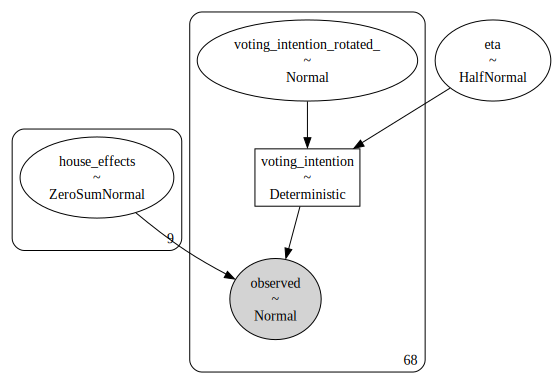

Compiling...
Compilation time = 0:00:01.884273
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:05:42.263738
Transforming variables...
Transformation time = 0:00:03.779201


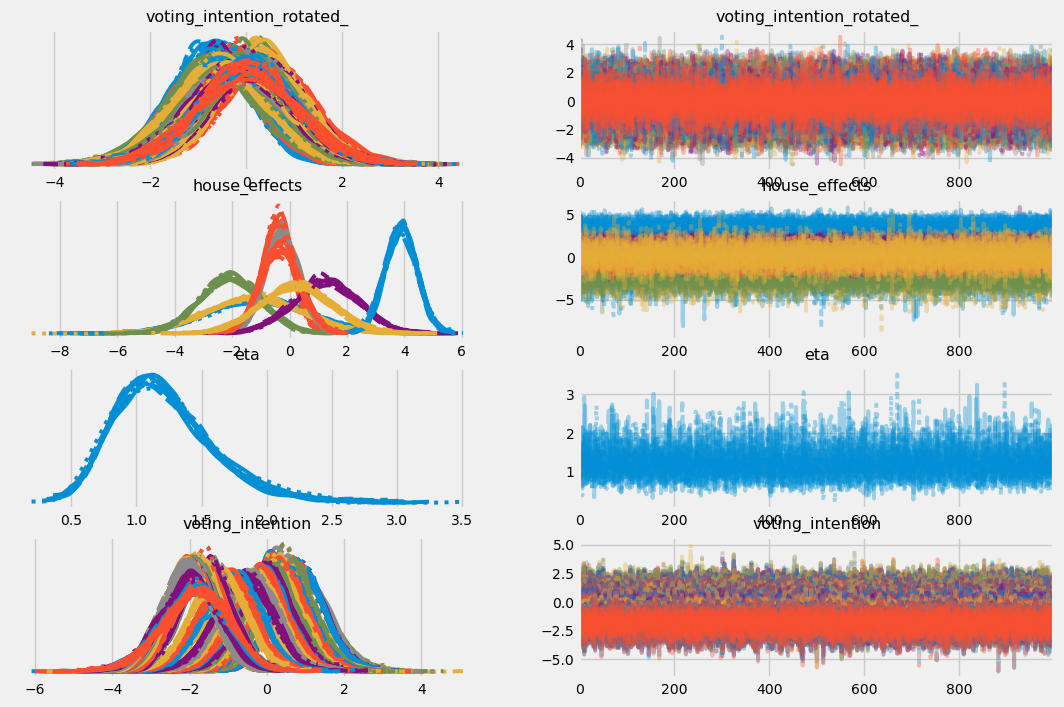

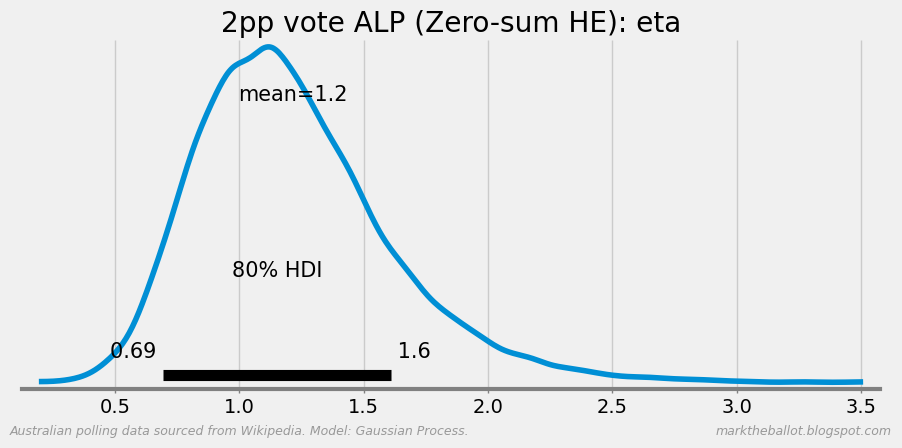

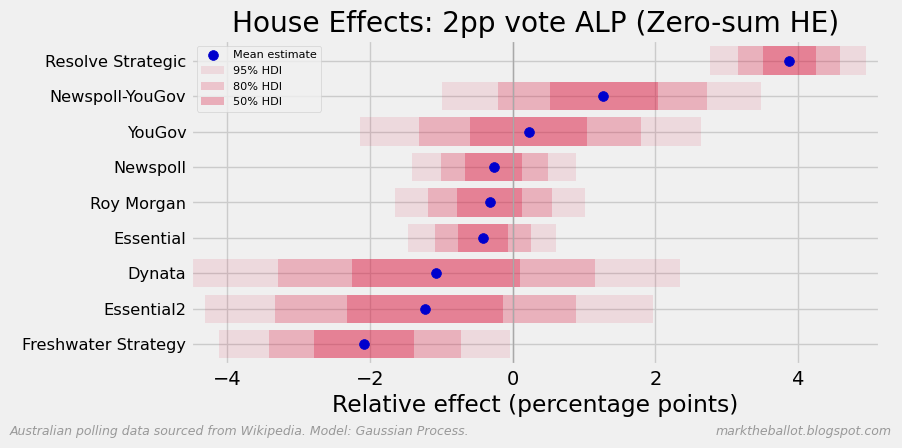

COLUMN: 2pp vote L/NP


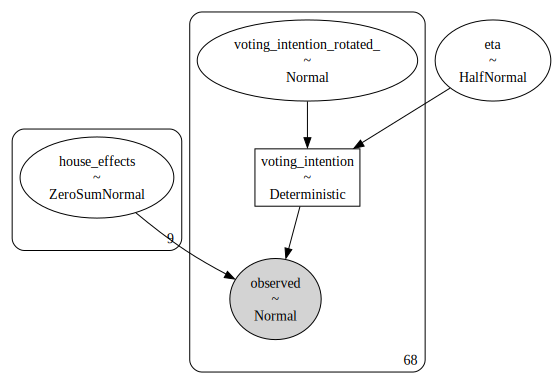

Compiling...
Compilation time = 0:00:01.838718
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:06:22.548485
Transforming variables...
Transformation time = 0:00:06.006605


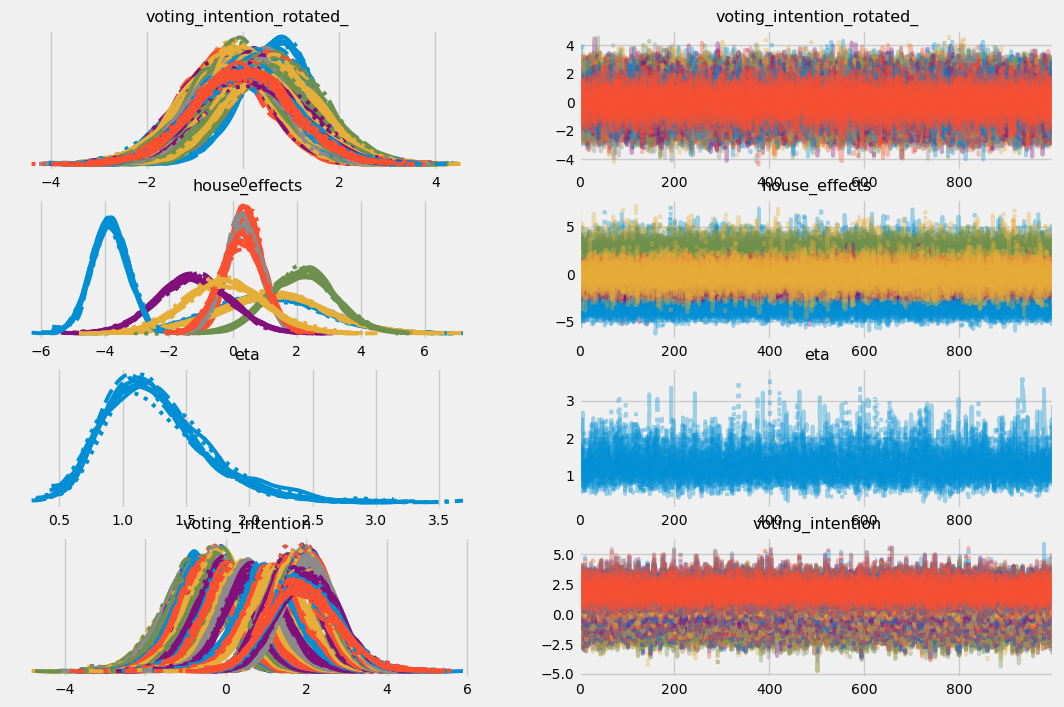

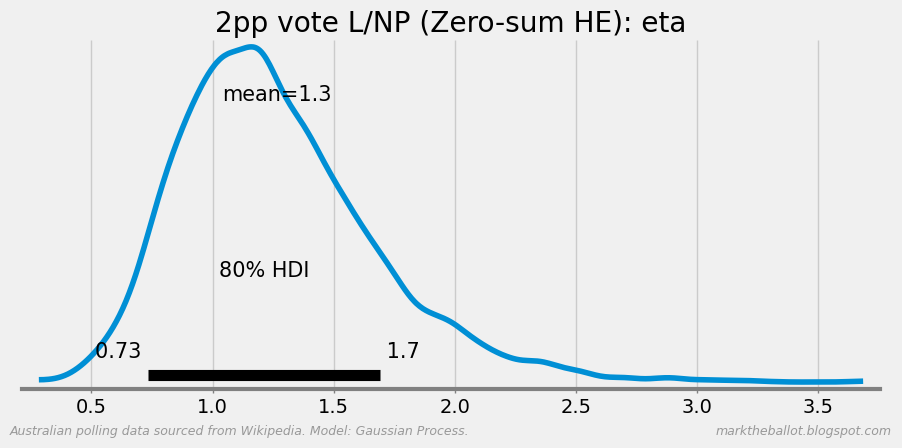

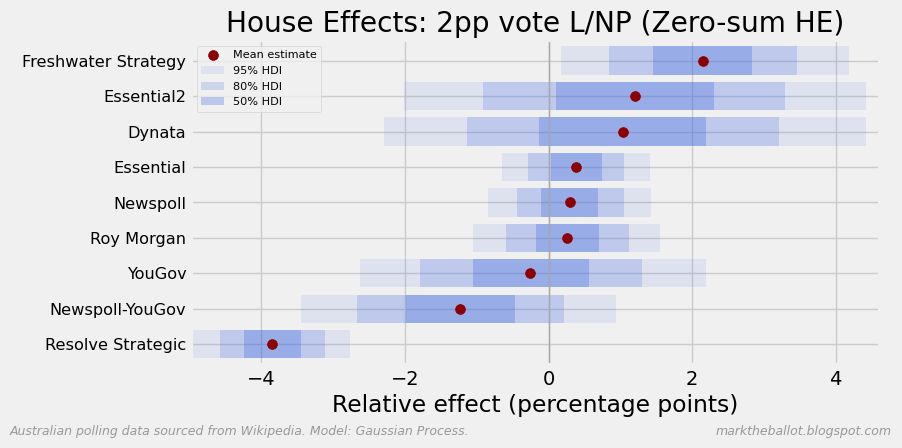

COLUMN: Primary vote ALP


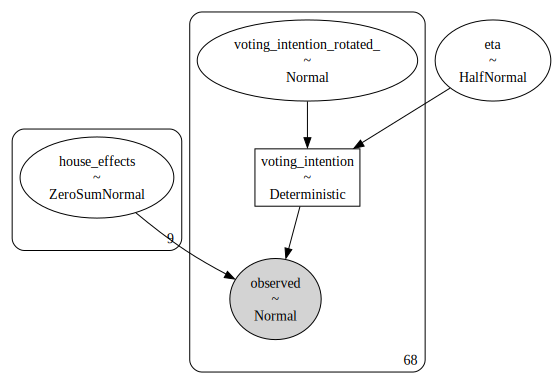

Compiling...
Compilation time = 0:00:01.852905
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# do the analysis
approach = "Zero-sum HE"
for column in chart:
    print(f"COLUMN: {column}")

    # Construct and run the model ...
    inputs = bayes_tools.prepare_data_for_analysis(
        df, column
    )
    model = pm.Model()
    house_effects = bayes_tools.house_effects_model(inputs, model)
    with model:
        length_scale = 30  # pm.Gamma("length", alpha=2, beta=1)
        eta = pm.HalfNormal("eta", sigma=5)
        cov = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)
        gp = pm.gp.Latent(cov_func=cov)
        X = np.c_[inputs["poll_day"]]  # column vector
        voting_intention = gp.prior("voting_intention", X=X)

        # Student-T
        #sigma = pm.HalfNormal("sigma", sigma=2.0)
        #nu = 1 + pm.Gamma(
        #    "nu", alpha=2, beta=0.1
        #)  # add one because student t is undefined for degrees of freedom less than one
        #observed = pm.StudentT(
        #    "observed", 
        #    mu=voting_intention + house_effects[inputs["poll_firm"]],
        #    lam=1.0 / sigma, 
        #    nu=nu, 
        #    observed=inputs["zero_centered_y"],
        #)

        # Normal
        observed = pm.Normal(
            "observed", 
            mu=voting_intention + house_effects[inputs["poll_firm"]],
            sigma=inputs["measurement_error_sd"], 
            observed=inputs["zero_centered_y"]
        )
        
    generate_model_map(model, filemame_tag=f"gp-{column}", display_images=True)
    idata = bayes_tools.draw_samples(model, nuts_sampler="numpyro")
    
    # plot the results
    line_color = plotting.get_color(column)
    point_color = plotting.contrast(line_color)
    title_stem = f"{column} ({approach})"
    bayes_tools.plot_univariate(
        idata,
        var_names=("eta", "length_scale", "sigma", "nu", ),
        title_stem=f"{title_stem}: ",
        tag="-GP",
        lfooter=LFOOTER,
        show=SHOW,
    )
    bayes_tools.plot_house_effects(
        inputs,
        idata,
        line_color,
        point_color,
        title=f"House Effects: {title_stem}",
        tag="-GP",
        lfooter=LFOOTER,
        show=SHOW,
    )

## Finished

In [ ]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

In [ ]:
print("Finished")